In [1]:
import pandas as pd, numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix

## Reading Data

In [2]:
# pred = pd.read_csv("../result/first-CommonNeighbours(10).csv", header=None)
pred = pd.read_csv("../result/first-CommonNeighbours(5).csv", header=None)
actual = pd.read_csv("../data/second_nodate.csv", header=None)
full = pd.read_csv("../data/twitter.csv")

In [3]:
print(pred.shape)
print(actual.shape)

(94573, 2)
(25530, 2)


## Baseline statistics

In [4]:
# Random probability chance of predicting
num_all_possibilities = len(full['Source'].unique())**2
rand_prob = len(actual)/num_all_possibilities
print("Random probability chance of predicting edge: " + str(rand_prob))

Random probability chance of predicting edge: 3.7110927444952833e-06


## CalculatingAccuracy

In [5]:
pred.head()

,0,1
0,(111743,104550)
1,(48273,78437)
2,(70841,71106)
3,(74841,12677)
4,(21980,86573)


In [6]:
pred.columns

Int64Index([0, 1], dtype='int64')

In [7]:
pred['edge'] = pred[0].astype(str) + ',' + pred[1].astype(str)
pred.head()

,0,1,edge
0,(111743,104550),"(111743,104550)"
1,(48273,78437),"(48273,78437)"
2,(70841,71106),"(70841,71106)"
3,(74841,12677),"(74841,12677)"
4,(21980,86573),"(21980,86573)"


In [8]:
pred['edge'][0]

'(111743,104550)'

In [9]:
actual['edge'] = '(' + actual[0].astype(str) + ',' + actual[1].astype(str) + ')'
actual.head()

,0,1,edge
0,8,1464,"(8,1464)"
1,8,1986,"(8,1986)"
2,8,17191,"(8,17191)"
3,8,23214,"(8,23214)"
4,15,83,"(15,83)"


In [10]:
# changing dtypes
for col in actual.columns:
    actual[col] = actual[col].apply(str)
    
for col in pred.columns:
    pred[col] = pred[col].apply(str)

In [11]:
# Calculating true positive
correct = pd.merge(actual, pred, on=['edge'])
# df = pd.merge(df1, df2, on=['document_id','item_id'])

In [20]:
print("Total number of predicted edges: " + str(len(pred)))
print("Number of correct predicted edges: " + str(len(correct)))
print("Total number of edges: " + str(len(actual)))
print("Recall: " + str(len(correct)/len(actual)))

Total number of predicted edges: 94573
Number of correct predicted edges: 855
Total number of edges: 25530
Recall: 0.033490011750881316


### Calculating values for confusion matrix

In [13]:
P = len(actual)
# Below are all positives. 
TP = len(correct)
FN = P - TP  # misclassified positives

N = num_all_possibilities - P
# Below are all negatives
FP = len(pred) - len(correct)
TN = N - FP

In [22]:
print("SUM: " + str(TP + FP + TN + FN))
print("Number of all possibilities: " + str(num_all_possibilities))

SUM: 6879375364
Number of all possibilities: 6879375364


## Metrics

In [27]:
recall = TP/P
precision = TP/(TP+FP)
print("Recall: " + str(recall))
print("Precision: " + str(precision))

Recall: 0.033490011750881316
Precision: 0.00904063527645311


In [16]:
array = [[TP, FP], [TN, FN]]
conf_matrix = pd.DataFrame(array)
conf_matrix_norm = conf_matrix.apply(lambda x: x/num_all_possibilities)

In [17]:
conf_matrix_norm

,0,1
0,1.242845e-07,0.000014
1,9.999827e-01,0.000004


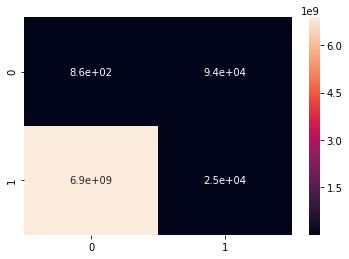

In [18]:
sns.heatmap(conf_matrix, annot=True)

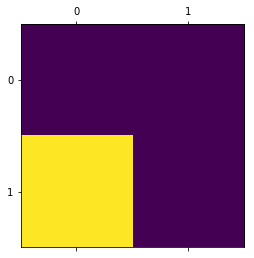

In [19]:
plt.matshow(conf_matrix)